# GSoC Coding challenge

Current

In [1]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [2]:
import json

In [3]:
import numpy as np

In [4]:
import re

Future

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
import xml.etree.ElementTree as ET
import requests

## Loading dictionaries

### Git

In [2]:
import git

In [3]:
def clone_folder(name='apertium-trunk', target='./data/'):
    repo = git.Repo.clone_from('https://github.com/apertium/'+name+'/', target)
    for i in git.objects.submodule.root.RootModule(repo).list_items(repo):
        git.Repo.clone_from('https://github.com/apertium/'+i.name, './data/'+i.name)
        logging.info(i.name)

In [4]:
clone_folder()

2018-05-14 20:51:12,126 | INFO : apertium-en-gl
2018-05-14 20:54:12,730 | INFO : apertium-eo-fr
2018-05-14 20:54:17,434 | INFO : apertium-crh-tur
2018-05-14 20:57:49,735 | INFO : apertium-hbs-slv
2018-05-14 20:58:24,846 | INFO : apertium-swe-dan
2018-05-14 21:21:52,622 | INFO : apertium-br-fr
2018-05-14 21:23:38,604 | INFO : apertium-oc-ca
2018-05-14 21:56:55,938 | INFO : apertium-sme-nob
2018-05-14 21:59:23,435 | INFO : apertium-eo-ca
2018-05-14 22:02:04,268 | INFO : apertium-eu-es
2018-05-14 22:03:48,823 | INFO : apertium-srd-ita
2018-05-14 22:06:30,437 | INFO : apertium-spa-ita
2018-05-14 22:10:13,711 | INFO : apertium-eo-es
2018-05-14 22:11:33,539 | INFO : apertium-rus-ukr
2018-05-14 22:11:39,270 | INFO : apertium-pt-ca
2018-05-14 22:16:13,588 | INFO : apertium-dan-nor
2018-05-14 22:16:53,887 | INFO : apertium-oc-es
2018-05-14 22:17:49,422 | INFO : apertium-bel-rus
2018-05-14 22:26:17,121 | INFO : apertium-isl-eng
2018-05-14 22:27:33,579 | INFO : apertium-hbs-eng
2018-05-14 22:27:3

### PyGithub

In [7]:
from github import Github

In [8]:
with open ('secure.json') as f:
    SECRET = json.loads(f.read())

In [9]:
github = Github(SECRET['USER'], SECRET['PASSWORD'])

In [10]:
user = github.get_user('apertium')

In [11]:
user.name

'Apertium'

In [12]:
def repo_names(user):
    for repo in user.get_repos():
        if re.match('apertium-[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?', repo.name):
            yield repo.name

In [ ]:
list(repo_names(user))

In [124]:
repo = github.get_repo('apertium/apertium-afr-nld')

In [14]:
def download(user):
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if not bidix:
            print (repo_name)

In [13]:
def bidix_url(repo):
    bidix = repo.name+'.'+repo.name.replace('apertium-','')+'.dix'
    for i in repo.get_dir_contents('/'):
        if re.match('apertium-.*?\.[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?.dix', i.path):
            return i.download_url

In [142]:
download(user)

apertium-en-lv
apertium-est-nor
apertium-ita-srd
apertium-ky-en
apertium-lex-tools
apertium-on-github
apertium-ru-cu
apertium-sc-pt
apertium-urd-pan


All these repos do not have bidixes except for the lat one. There are two of them. So that's strange.

In [143]:
def download(user):
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        print(bidix)
        

In [ ]:
download(user)

In [145]:
def tree(url):
    response = requests.get(url)
    return ET.fromstring(response.content)

In [172]:
%time w = list(repo_names(user))

Wall time: 29.3 s


In [174]:
%time bidix_url(github.get_repo(user.name+'/'+w[0]))

Wall time: 1.59 s


'https://raw.githubusercontent.com/apertium/apertium-afr-nld/master/apertium-afr-nld.afr-nld.dix'

In [167]:
def download():
    for repo_name in repo_names(user):
        url = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if url:
            lang = re.findall('\.([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})\.dix$', url)
            l1, l2 = lang[0][0], lang[0][1]
            try:
                t = tree(url)
            except:
                print(l1, l2)

In [168]:
%time download()

eo bg
eo fa
eo pl
fin fra
pl lv
sah eng
Wall time: 12min 6s


** only relevant for certain language pair **

In [100]:
G = nx.Graph()

In [101]:
G.nodes()

[]

In [46]:
def get_repos_for_pair(user, l1, l2):
    G = nx.Graph()
    lg = (l(l1,3), l(l2,3))
    for name in repo_names(user):
        w = re.findall('.*?-([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})$', name)[0]
        w = (l(w[0],3), l(w[1],3))
        G.add_edge(w[0],w[1])
    G.remove_edge(lg[0], lg[1])
    return G

In [47]:
%time G = get_repos_for_pair(user, 'tat', 'rus')

Wall time: 1min 22s


In [75]:
l1 = 'tat'
l2 = 'ru'
lg = (l(l1,3), l(l2,3))

In [ ]:
%time nx.node_connected_component(G, lg[0]) & nx.node_connected_component(G, lg[1])

In [54]:
w = np.array([np.array(i) for i in nx.all_simple_paths(G, source=lg[0], target=lg[1], cutoff=5)])

In [68]:
len(G.nodes())

164

In [116]:
l1 = 'urd'
l2 = 'hin'
lg = (l(l1,3), l(l2,3))

9


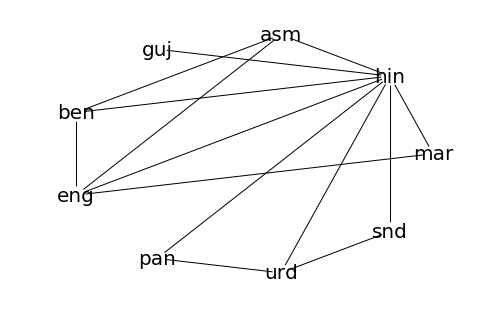

In [117]:
w = nx.single_source_shortest_path_length(G, lg[0], cutoff=2)
v = nx.single_source_shortest_path_length(G, lg[1], cutoff=2)
nodes = list((set(w.keys())&set(w.keys()) )| set([lg[0],lg[1]]))
print (len(nodes))
nx.draw_shell(G.subgraph(nodes), with_labels = True, font_size = 20, node_color = 'white')
plt.show()

In [45]:
np.array([list([1]),list([2,3,4])])

array([list([1]), list([2, 3, 4])], dtype=object)

In [34]:
np.unique(np.array([list([1]),list([2])]))

array([1, 2])

In [108]:
l('zul',2)

'zul'

## Language codes

In [17]:
from numpy import nan

In [18]:
import pandas as pd

In [19]:
lang_codes = pd.read_csv('./files/language-codes-full_csv.csv', na_values = 0)
lang_codes = lang_codes[['alpha3-b','alpha2']]
lang_codes = lang_codes.dropna()

In [71]:
lang_codes.head()

,alpha3-b,alpha2
0,aar,aa
1,abk,ab
8,afr,af
10,aka,ak
12,alb,sq


In [72]:
lang_codes = [{i[0]:i[1] for i in np.array(lang_codes)}, {i[1]:i[0] for i in np.array(lang_codes)}]

In [73]:
with open ('./files/lang_codes.json', 'w') as f:
    json.dump(lang_codes, f)

In [20]:
with open ('./files/lang_codes.json', 'r') as f:
    lang_codes = json.load(f)

In [21]:
def l(lang, mode=3):
    mode = mode % 2
    if len(lang)==2:
        if lang in lang_codes[mode]:
            return lang_codes[mode][lang]
        else:
            return lang
    else:
        return lang

In [78]:
l('tt', 3)

'tat'

## Object classes

** Word **

- lemma : lemma
- lang : language
- pos : part of speech

In [ ]:
class Word:
    def __init__(self, lemma, lang, pos, add=[]):
        self.lemma = lemma
        self.lang = lang
        self.pos = pos
        self.add = add
    
    def __str__(self):
        return (str(self.lang)+'_'+str(self.lemma)+'_'+str(self.pos))+'_'+str('-'.join(self.add))
    
    __repr__ = __str__
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and self.pos == other.pos
    
    def __hash__(self):
        return hash(str(self))

In [ ]:
#

In [ ]:
def parse_and_add(file, lang1, lang2, G):
    